In [115]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [195]:
maxAcc = 0.0
maxIter = 0
#C_Lambda is the regularizer for the closed form solution.
C_Lambda = 0.05
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
#M is the number of basis functions
M = 5
PHI = []
IsSynthetic = False

In [196]:
#Getting the array vector of Target values from 'Querylevelnorm_t.csv'.
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

#Getting the matrix of total data from 'Querylevelnorm_X.csv'.
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        #since the variance for 5,6,7,8,9 is very less or 0 therefore, we will do np.delete[5,6,7,8,9]
        #axis=1 represents the columns that contain features
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix

#Getting the number of rows for training target which is 80% of the total target dataset
#Final list of size 80% of the total target data will be returned.
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

#Getting the number of rows and columns for trining data which is 80% of total length of the data.
#Final array of (number of features,total number of rows) will be obtained.
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

#Generating the array of validation data which is 10% of total length
#Final array of (number of features,10% of the total data) dimensions will be obtained.
def GenerateValData(rawData, ValPercent, TrainingCount): 
    #ceil() returns ceiling value of x i.e the smallest integer not less than x.
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount:V_End-1]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#Generating the list of validation target values which is 10% of total length
#List of size 10% of the total length will be obtained.
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount:V_End-1]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

#Generating BigSigma matrix using MuMatrix which can be obtained using K-means clustering method.
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    #np.zeros returns the array of given shape and type, padded with zeros.
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

#In order to obtain phi we are calculating the scalar 
#Scalar needs Data,Mu and inverse of Bigsigma
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

#We are calculating the phi of x using Radial Basis function in the below method.
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

#Below function defines the calculation of phi matrix for the closed form solution.
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

#Below method defines the calculation used to obtain wieghts in closed form solution using phi matrix,
# target training values and regularizer
def GetWeightsClosedForm(PHI, T, Lambda):
    #np.identity is used to return the identity matrix
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

#In the below method we are evaluating the validation test.
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

#In the below method, we are calculating the erms for the closed form solution.
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [197]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 'U' mode is deprecated
  


## Prepare Training Data

In [198]:
#We have used np.array for TrainingTarget because it is of list type. Therefore,
#in order to change it to array type we need to used np.array function.
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [199]:
#We have used np.array for ValDataAct because it is of list type and we want
# it to be of array type
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [200]:
##We have used np.array for TestDataAct because it is of list type and we want
# it to be of array type
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [201]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [202]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(5, 41)
(41, 41)
(55699, 5)
(5,)
(6962, 5)
(6962, 5)


## Finding Erms on training, validation and test set 

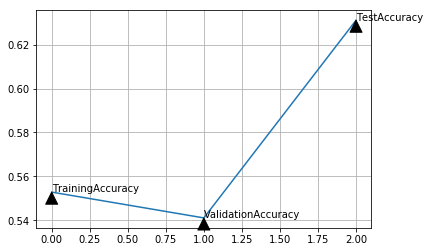

In [203]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
TrainingAccuracy_flt=float(TrainingAccuracy.split(',')[1])
ValidationAccuracy_flt=float(ValidationAccuracy.split(',')[1])
TestAccuracy_flt=float(TestAccuracy.split(',')[1])
#In order to plot the graph
plt.plot([TrainingAccuracy_flt,ValidationAccuracy_flt,TestAccuracy_flt])
plt.annotate('TrainingAccuracy', (0,TrainingAccuracy_flt), (0,TrainingAccuracy_flt),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('ValidationAccuracy', (1,ValidationAccuracy_flt), (1,ValidationAccuracy_flt),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('TestAccuracy', (2,TestAccuracy_flt), (2,TestAccuracy_flt),
            arrowprops=dict(facecolor='black', shrink=0.01),
            )
plt.grid()
plt.show()

In [90]:
print ('UBITname      = ektakati')
print ('Person Number = 50291702')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = 10 \nLambda = 0.9")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

UBITname      = ektakati
Person Number = 50291702
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.9
E_rms Training   = 0.5439095333876482
E_rms Validation = 0.5372442060967044
E_rms Testing    = 0.6239043366638996


## Gradient Descent solution for Linear Regression

In [12]:
print ('-----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('-----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [217]:
#W_Now is the random weight we have initialized to the data nodes in our model
W_Now        = np.dot(1, W)
#La is the regularizer to avoid the noisy data nodes in our model and to obtain
# generalized curve.
La           = 1
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,200):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    #Delta_E_D is difference between the expected and observed outcomes of the model.
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    #La_Delta_E_W is the change in weights that can be calculated by multiplying
    #the initial weight and the regularizer we have taken for our model.
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    #Old weights will now be updated with the new weights.
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    #We are testing the accuracy of outcomes of the model based on the training data set provided
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    #We are testing the accuracy of outcomes of the model based on the validation data set.
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    #We are testing the accuracy of outcomes of the model based on the test data set.
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.55284
E_rms Validation = 0.54104
E_rms Testing    = 0.62682


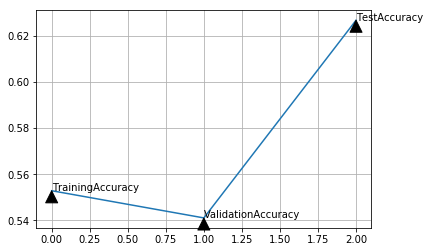

In [218]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
TrainingAccuracy_flt=float(np.around(min(L_Erms_TR),5))
ValidationAccuracy_flt=float(np.around(min(L_Erms_Val),5))
TestAccuracy_flt=float(np.around(min(L_Erms_Test),5))
#In order to plot the graph
plt.plot([TrainingAccuracy_flt,ValidationAccuracy_flt,TestAccuracy_flt])
plt.annotate('TrainingAccuracy', (0,TrainingAccuracy_flt), (0,TrainingAccuracy_flt),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('ValidationAccuracy', (1,ValidationAccuracy_flt), (1,ValidationAccuracy_flt),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('TestAccuracy', (2,TestAccuracy_flt), (2,TestAccuracy_flt),
            arrowprops=dict(facecolor='black', shrink=0.01),
            )
plt.grid()
plt.show()